In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling
import plotly.express as px
import plotly.graph_objects as go
import sklearn.metrics as metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix
from xgboost import XGBClassifier
# from pywaffle import Waffle
# from yellowbrick.classifier import classification_report

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_gs = pd.read_csv('gender_submission.csv')

In [3]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [10]:
df_gs

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# DATA VISUALISASI

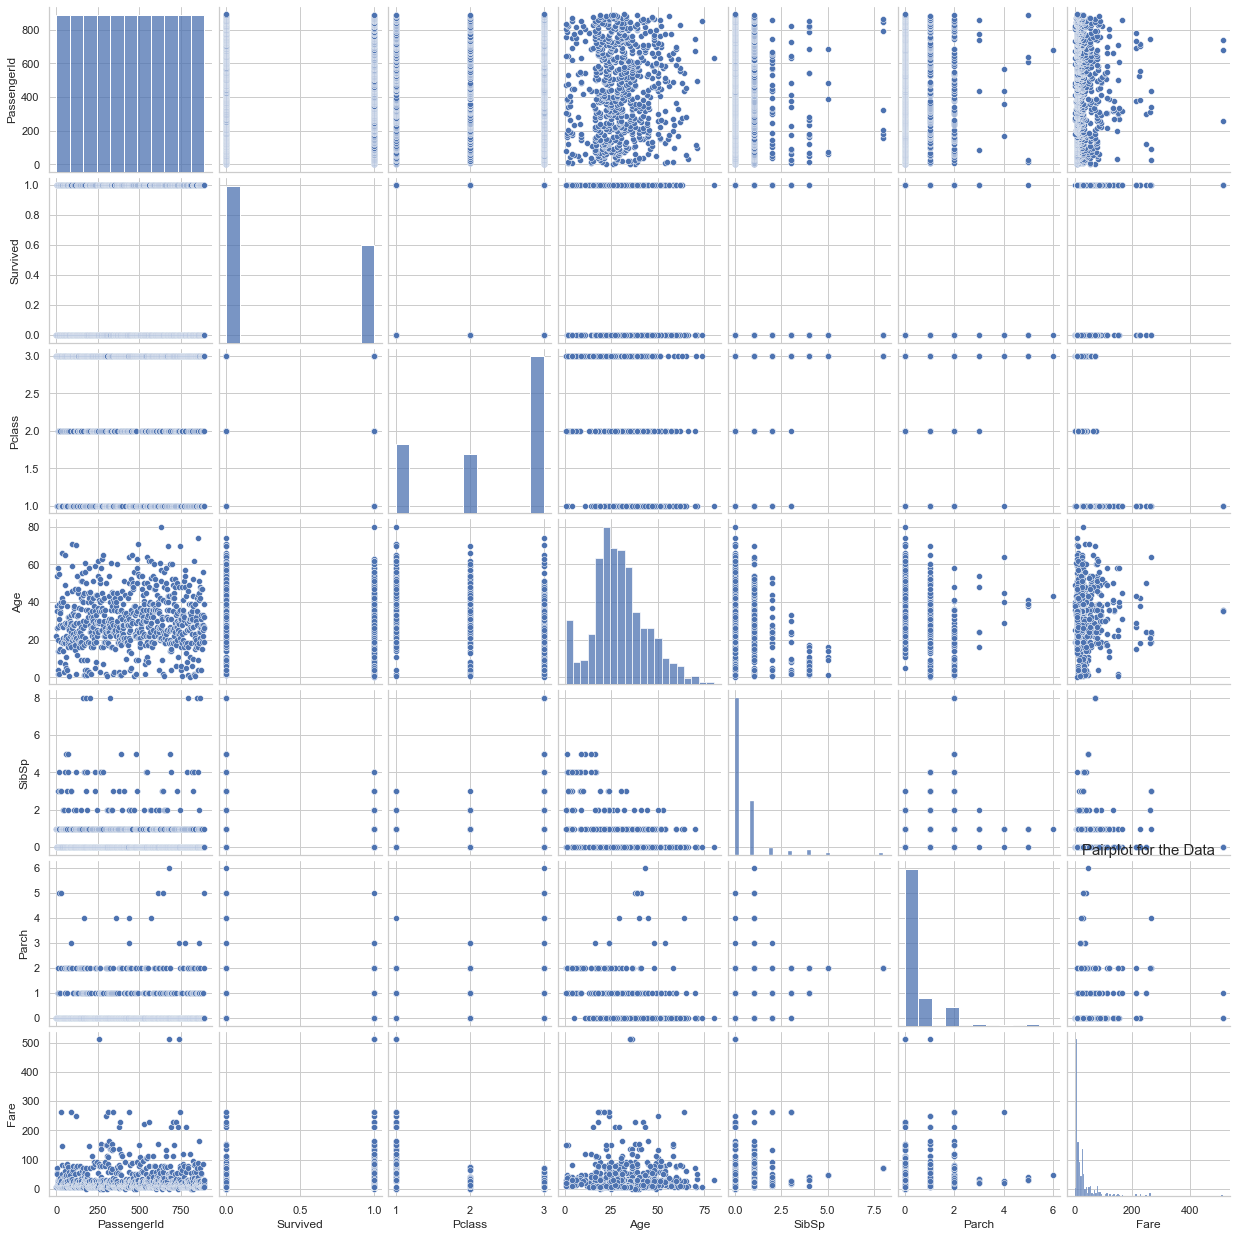

In [44]:
sns.pairplot(df_train)
plt.title('Pairplot for the Data', fontsize = 15)
plt.show()

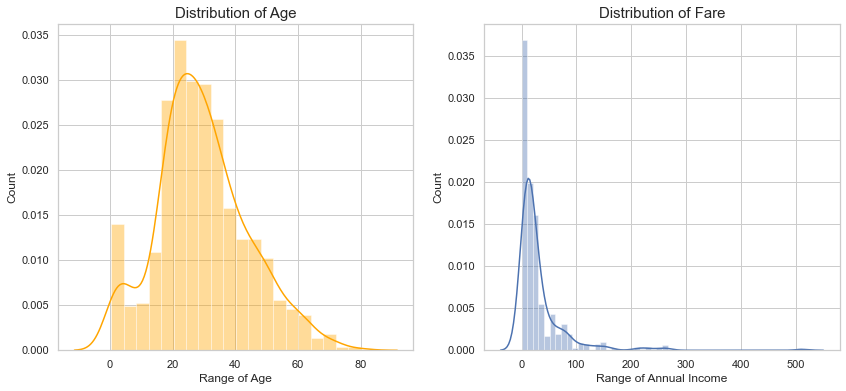

In [40]:
import seaborn as sns
import warnings
plt.rcParams['figure.figsize'] = (14, 6)
plt.subplot(1, 2, 1)
warnings.filterwarnings('ignore')
sns.set(style = 'whitegrid')
sns.distplot(df_train['Age'], color = 'orange')
plt.title('Distribution of Age', fontsize = 15)
plt.xlabel('Range of Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(df_train['Fare'])
plt.title('Distribution of Fare', fontsize = 15)
plt.xlabel('Range of Annual Income')
plt.ylabel('Count')
plt.show()

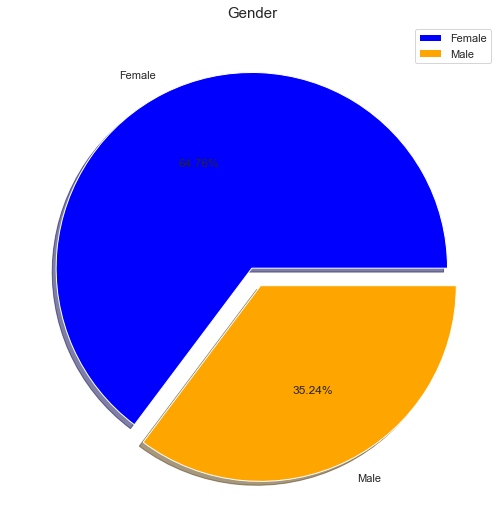

In [42]:
labels = ['Female', 'Male']
size = df_train['Sex'].value_counts()
colors = ['blue', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

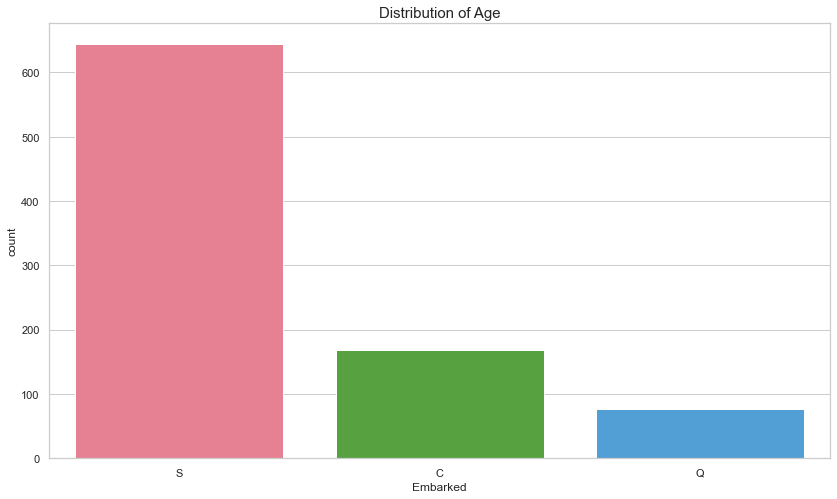

In [46]:
plt.rcParams['figure.figsize'] = (14, 8)
sns.countplot(df_train['Embarked'], palette = 'husl')
plt.title('Distribution of Embarked', fontsize = 15)
plt.show()

Text(0.5, 1.0, 'Correlation Factors Heat Map')

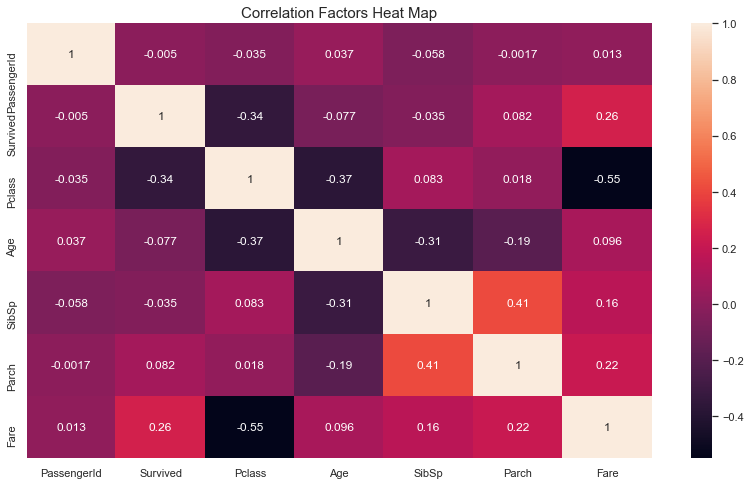

In [47]:
sns.heatmap(df_train.corr(), annot=True).set_title('Correlation Factors Heat Map', size='15')

# CEK ISNA dan ISNULL

In [14]:
print('jumlah dari df_train kolom yang kosong :\n\n', df_train.isnull().sum())
print('jumlah dari df_test kolom yang kosong :\n\n', df_test.isnull().sum())
print('jumlah dari df_gs kolom yang kosong :\n\n', df_gs.isnull().sum())

print('jumlah dari df_train kolom yang Na :\n\n', df_train.isna().sum())
print('jumlah dari df_test kolom yang Na :\n\n', df_test.isna().sum())
print('jumlah dari df_gs kolom yang Na :\n\n', df_gs.isna().sum())

jumlah dari df_train kolom yang kosong :

 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
jumlah dari df_test kolom yang kosong :

 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
jumlah dari df_gs kolom yang kosong :

 PassengerId    0
Survived       0
dtype: int64
jumlah dari df_train kolom yang Na :

 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
jumlah dari df_test kolom yang Na :

 PassengerId      0
Pclass           0
Name     

# FILLING Na or NaN DATA

In [15]:
df_train['Cabin'] = df_train['Cabin'].apply(lambda i: i[0] if pd.notnull(i) else 'Z')
df_test['Cabin'] = df_test['Cabin'].apply(lambda i: i[0] if pd.notnull(i) else 'Z')

In [16]:
df_train['Cabin'].unique()
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Z,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Z,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Z,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Z,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,Z,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C


In [17]:
df_train1=df_train.copy()
df_test1=df_test.copy()
df_train1.drop(['PassengerId','Name','Ticket'], axis= 1, inplace= True)
df_test1.drop(['PassengerId','Name','Ticket'], axis= 1, inplace= True)

df_train1.fillna(df_train1['Age'].median(), inplace= True)
df_test1.fillna(df_test1['Age'].median(), axis =1, inplace= True)

df_test1.fillna(df_test1['Fare'].median(), axis =1, inplace= True)

print('jumlah dari df_train1 kolom yang kosong :\n\n', df_train.isnull().sum())
print('jumlah dari df_test1 kolom yang kosong :\n\n', df_test.isnull().sum())
print('jumlah dari df_gs1 kolom yang kosong :\n\n', df_gs.isnull().sum())

print('jumlah dari df_train1 kolom yang Na :\n\n', df_train.isna().sum())
print('jumlah dari df_test1 kolom yang Na :\n\n', df_test.isna().sum())
print('jumlah dari df_gs1 kolom yang Na :\n\n', df_gs.isna().sum())

jumlah dari df_train1 kolom yang kosong :

 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64
jumlah dari df_test1 kolom yang kosong :

 PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin           0
Embarked        0
dtype: int64
jumlah dari df_gs1 kolom yang kosong :

 PassengerId    0
Survived       0
dtype: int64
jumlah dari df_train1 kolom yang Na :

 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64
jumlah dari df_test1 kolom yang Na :

 PassengerId     0
Pclass          0
Name            0

In [18]:
df_train2 = df_train1.copy()
df_test2=df_test1.copy()
df_train1

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,Z,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,Z,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,Z,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,Z,S
887,1,1,female,19.0,0,0,30.0000,B,S
888,0,3,female,28.0,1,2,23.4500,Z,S
889,1,1,male,26.0,0,0,30.0000,C,C


# Label Encoding

In [19]:
df_train1.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [20]:
labelencoder = LabelEncoder()

df_train2['Sex'] = labelencoder.fit_transform(df_train2['Sex'])
df_test2['Sex'] = labelencoder.fit_transform(df_test2['Sex'])
df_train2['Cabin'] = labelencoder.fit_transform(df_train2['Cabin'])
df_test2['Cabin'] = labelencoder.fit_transform(df_test2['Cabin'])

def replace_row_embarked(row):
    if(row is 'C'): 
        return 1
    elif(row is 'Q'):
        return 2
    elif(row is 'S'):
        return 3
    else:
        return 0
df_train2["Embarked"] = df_train2["Embarked"].apply(lambda x : replace_row_embarked(x))
df_test2["Embarked"] = df_test2["Embarked"].apply(lambda x : replace_row_embarked(x))
df_train2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,8,3
1,1,1,0,38.0,1,0,71.2833,2,1
2,1,3,0,26.0,0,0,7.9250,8,3
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,8,3
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,8,3
887,1,1,0,19.0,0,0,30.0000,1,3
888,0,3,0,28.0,1,2,23.4500,8,3
889,1,1,1,26.0,0,0,30.0000,2,1


# Normalization

In [21]:
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
df_train3=pd.DataFrame(min_max.fit_transform(df_train2[['Survived','Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]),columns=df_train2[['Survived','Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].columns)
df_train3.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.014151,1.000000
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.139136,0.333333
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469,1.000000
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.103644,1.000000
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.015713,1.000000


In [22]:
min_max=MinMaxScaler()
df_test3=pd.DataFrame(min_max.fit_transform(df_test2[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]),columns=df_test2[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].columns)
df_test3.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,1.0


# APPLY MACHINE LEARNING

In [23]:
x0 = df_train3.copy(deep=True)
x = x0.drop(['Survived'],axis =1)
x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,0.271174,0.125,0.000000,0.014151,1.000000
1,0.0,0.0,0.472229,0.125,0.000000,0.139136,0.333333
2,1.0,0.0,0.321438,0.000,0.000000,0.015469,1.000000
3,0.0,0.0,0.434531,0.125,0.000000,0.103644,1.000000
4,1.0,1.0,0.434531,0.000,0.000000,0.015713,1.000000
...,...,...,...,...,...,...,...
886,0.5,1.0,0.334004,0.000,0.000000,0.025374,1.000000
887,0.0,0.0,0.233476,0.000,0.000000,0.058556,1.000000
888,1.0,0.0,0.346569,0.125,0.333333,0.045771,1.000000
889,0.0,1.0,0.321438,0.000,0.000000,0.058556,0.333333


In [24]:
y=df_train3['Survived']
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 891, dtype: float64

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=500)

In [26]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
ran2 = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1)
knn = KNeighborsClassifier(n_neighbors=100)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
xgb = XGBClassifier()
naive = GaussianNB()

models = {"Decision tree" : dec,
          "Random forest" : ran,
          "Random forest Tuning" : ran2,
          "KNN" : knn,
          "SGD" : sgd,
          "Naive bayes" : naive,
          "XGBoost" : xgb}
scores= { }

for key, value in models.items():    
    model = value
    model.fit(x_train, y_train)
    scores[key] = model.score(x_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.1s finished


In [27]:
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

,Accuracy Score
Random forest Tuning,0.804469
KNN,0.793296
XGBoost,0.793296
Decision tree,0.787709
Random forest,0.765363
SGD,0.765363
Naive bayes,0.754190


In [28]:
y_pred_train=ran2.predict(x_train)
y_pred_test=ran2.predict(x_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.1s finished


In [29]:
print("Training accuracy: ", accuracy_score(y_train, y_pred_train))
print("Testing accuracy: ", accuracy_score(y_test, y_pred_test))

Training accuracy:  0.8735955056179775
Testing accuracy:  0.8044692737430168


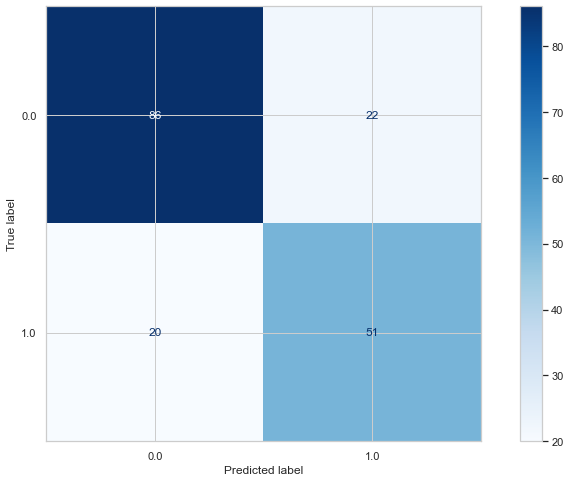

In [48]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(ran, x_test, y_test,cmap=plt.cm.Blues)

In [31]:
ran2.fit(x_train, y_train)

y_pred_train = ran2.predict(x_train)
y_pred_test = ran2.predict(x_test)

bla= accuracy_score(y_test,y_pred_test)
bla

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concur

0.8044692737430168

# SUBMIT FILEs

In [32]:
hasil0 = df_test2.copy(deep=True)
hasil = hasil0.drop(['Cabin'],axis =1)
hasil

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,2
1,3,0,47.0,1,0,7.0000,3
2,2,1,62.0,0,0,9.6875,2
3,3,1,27.0,0,0,8.6625,3
4,3,0,22.0,1,1,12.2875,3
...,...,...,...,...,...,...,...
413,3,1,27.0,0,0,8.0500,3
414,1,0,39.0,0,0,108.9000,1
415,3,1,38.5,0,0,7.2500,3
416,3,1,27.0,0,0,8.0500,3


In [33]:
preds = dec.predict(hasil)
preds

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0.

In [34]:
df_result = pd.DataFrame({'PassengerId':df_test["PassengerId"] ,'Survived' : preds})
df_result

,PassengerId,Survived
0,892,1.0
1,893,1.0
2,894,1.0
3,895,1.0
4,896,0.0
...,...,...
413,1305,1.0
414,1306,1.0
415,1307,1.0
416,1308,1.0


In [35]:
df_result.to_csv('gender_submission2.csv', index=False)